In [1]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle
from PIL import Image

from IPython.display import HTML, clear_output, display, update_display
import matplotlib.pyplot as plt


from simple import Game, get_valid_actions

from agent_code.simple_agent.wrapper import SimpleAgent

from agent_code.tensor_agent.agent import TensorAgent
from agent_code.tensor_agent.hyperparameters import hp
from agent_code.tensor_agent.X import RelativeX3 as game_state_X
from agent_code.tensor_agent.X import AbsoluteX3, X3_to_imgs
from agent_code.tensor_agent.model import FullModel, Counter

choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
action_y_map = {choices[i]: i for i in range(len(choices))}
D = len(choices)

clear_output()

In [2]:
hp.buffer_size = 100000
hp.target_network_period = 32000
hp.epsilon = 0.
hp.learning_rate=0.001
hp.discount_factor=0.99
hp.peaceful = False

aux_rewards = {
    e.WAITED: -0.1,
    e.CRATE_DESTROYED: 0.2,
    e.COIN_COLLECTED: 1,
    e.KILLED_OPPONENT: 5,
    e.KILLED_SELF: 0,
    e.GOT_KILLED: 0
}

hurry_up = 1 * (1 - hp.discount_factor)

In [3]:
class HallOfFame:
    def __init__(self):
        self.weights = []
    
    def add(self, weights):
        self.weights.append(weights)
        if len(self.weights) > 50:
            self.weights = self.weights[::2]

HoF = HallOfFame()

In [4]:


K.clear_session()
#model = FullModel(game_state_X.shape, D)

def make_agent():
    return TensorAgent(game_state_X.shape, D, weights=None, model=FullModel(game_state_X.shape, D))

total_step = 0

tensor_agent = make_agent()

original = 'tensor_agent'
copies = [f'tensor_agent-copy{i}' for i in range(3)]
additional = [f'tensor_agent{i}' for i in range(3)]
simples = [f'simple_agent{i}' for i in range(3)]

agents = {
    original: tensor_agent
}

for n in copies:
    agents[n] = tensor_agent.clone()

for n in additional:
    agents[n] = make_agent()

for n in simples:
    agents[n] = SimpleAgent(game_state_X.shape, D, model=tensor_agent.model, er_buffer=tensor_agent.buffer)

train = {a: False for a in agents}

clear_output()

In [5]:
#tensor_agent.model.load_weights('models/self-play4/tensor_agent-model1500001.h5')

In [6]:
agents[additional[0]].model.load_weights('self-play3-900k.h5')
HoF.add(agents[additional[0]].model.get_weights())

loading weights
weights loaded


In [6]:
from agent_code.tensor_agent.layers import NoisyDense

for layer in tensor_agent.model.online.layers + tensor_agent.model.target.layers:
    if type(layer) == NoisyDense:
        layer.w_sigma.initializer.run(session=K.get_session())
        layer.b_sigma.initializer.run(session=K.get_session())

In [7]:
class AgentInfo(object):
    def __init__(self, agents, moving_rewards):
        self.agents = agents
        self.moving_rewards = moving_rewards

    def _repr_pretty_(self, pp, cycle):
        text = ''
        for n, a in self.agents.items():
            text +=  '=====================\n'
            text += f'{n} ({a.model.family}) \n'
            text += f'trained: {a.model.steps} \n'
            text += f'moving reward: {moving_rewards[n]:.2f} \n'
        pp.text(text)
        
    def __repr__(self):
        return str(self.agents.keys().join(','))

In [14]:
d = display(f'Starting...', display_id='progress')


n_steps = 3000000
game = None
current_agents = {}

train = {n: False for n in agents.keys()}
for n in [original] + copies + simples:
    train[n] = True
#train['tensor_agent'] = True

moving_rewards = {n: 0 for n in agents.keys()}
episode_count = 0

info = AgentInfo(agents, moving_rewards)
agent_display = display(info, display_id='agent_info')



for step in range(total_step, n_steps):
    if game is None:
        episode_count += 1
        
        #=== Choose Agents ===
        agent_choice = np.random.choice([1, 2, 3, 4], p=[0.1, 0.05, 0.05, 0.8])
        if agent_choice == 1:
            agent_choice = 'solo'
            current_agents = {n: agents[n] for n in [original]}
        else:
            agent_choices = np.random.choice(['hof', 'clones', 'simples'], agent_choice-1, p=[0.2, 0.6, 0.2])
            current_agents = {original: agents[original]}
            
            for key, cnt in zip(*np.unique(agent_choices, return_counts=True)):
                for i in range(cnt):
                    if key == 'hof':
                        if len(HoF.weights) > 2:
                            n = additional[i]
                            agents[n].model.set_weights(HoF.weights[np.random.choice(len(HoF.weights))])
                        else:
                            n = copies[i]
                    elif key == 'clones':
                        n = copies[i]
                    elif key == 'simples':
                        n = simples[i]
            
                    current_agents[n] = agents[n]
        
        
        #=== Choose Game ===
        choice = np.random.choice(['coins', 'deathmatch', 'full'], p=[0.1,0.,0.9])
        if choice == 'coins':
            game = Game(*Game.create_arena(current_agents.keys(), crate_density=0.), max_duration=100)
        elif choice == 'deathmatch' and agent_choice != 'solo':
            game = Game(*Game.create_arena(current_agents.keys(), crate_density=0., coins_per_area=0),\
                        max_duration=np.random.randint(100, 401))
        else: # 'full'
            game = Game(*Game.create_arena(current_agents.keys(),\
                                           crate_density=np.random.uniform(low=0.5, high=1.0)), \
                       max_duration=np.random.randint(100, 401))
        dead_rewards = {}

    total_step += 1
    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, b, _ = agent
        
        game_state = game.get_game_state(agent)
        Xs[name] = game_state_X.get(game_state)
        valid_actions = get_valid_actions(x, y, b, game)
        actions[name] = current_agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions, game_state=game_state)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    rewards, events = game.step(actions_as_string)
    
    ex_rewards = {}
    for name in actions.keys():
        moving_rewards[name] = 0.99 * moving_rewards[name] + rewards[name]
        ex_rewards[name] = rewards[name] + np.sum([events[name][event] * aux_rewards[event] for event in aux_rewards.keys()])
    
    #=== Delayed reward on death ===
    for name in actions.keys():
        if events[name][e.GOT_KILLED]:
            dead_rewards[name] = [ex_rewards[name], np.maximum(len(game.agents)-1, 1), Xs[name], actions[name]]
    
    for _,_,name,_,_ in game.agents:
        for dr in dead_rewards.values():
            dr[0] -= rewards[name]
    #===============================
    
    for _,_,name,_,_ in game.agents:
        reward = ex_rewards[name]
        for _,_,opponent,_,_ in game.agents:
            if opponent != name:
                reward -= rewards[opponent] / (len(game.agents) - 1)
        
        if game.terminated:
            reward -= np.sum(game.coins) / len(game.agents)
        
        if train[name]:
            current_agents[name].reward_update([Xs[name], actions[name], reward])
            
    
    agent_display.update(info)
    
    if step % 100000 == 0:
        tensor_agent.model.save(f'models/self-play6/tensor_agent-model{total_step}.h5')
    
    if game.terminated:
        # Apply delayed reward for death
        for name, dr in dead_rewards.items():
            if train[name]:
                current_agents[name].reward_update([dr[2], dr[3], (dr[0]-np.sum(game.coins))/dr[1]])
        
        for name, a in current_agents.items():
            a.end_of_episode() # alt: save=None
        
        if episode_count % 100 == 0:
            HoF.add(tensor_agent.model.get_weights())
        
        d.update(f'Episode {episode_count} Step: {step+1}/{n_steps}')
        game = None

d.update(f'Complete')

'Episode 7579 Step: 1535210/3000000'

tensor_agent (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 0.00 
tensor_agent-copy0 (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 0.00 
tensor_agent-copy1 (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 0.00 
tensor_agent-copy2 (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 0.01 
tensor_agent0 (vigilant_coin_collector) 
trained: 0 
moving reward: 1.03 
tensor_agent1 (adoring_crate_advocate) 
trained: 0 
moving reward: 2.53 
tensor_agent2 (confident_bomb_lover) 
trained: 0 
moving reward: 0.00 
simple_agent0 (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 3.51 
simple_agent1 (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 1.08 
simple_agent2 (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 2.62 


KeyboardInterrupt: 

In [18]:
tensor_agent.model.save(f'models/self-play6/tensor_agent-model{total_step}.h5')

In [26]:
d = display(f'Starting...', display_id='progress_test')

n_steps = 1000
game = None

current_agents = {n: agents[n] for n in [original] + copies}
train = {n: False for n in agents.keys()}
moving_rewards = {n: 0 for n in current_agents.keys()}

info = AgentInfo(current_agents, moving_rewards)
agent_display = display(info, display_id='agent_info_test')

imgs = []

for step in range(n_steps):
    if game is None:
        game = Game(*Game.create_arena(current_agents.keys(), crate_density=0.75))

    actions = {}
    Xs = {}
    img = np.zeros((17, 17, 4))
    
    for agent in game.agents:
        x, y, name, b, _ = agent
        
        game_state = game.get_game_state(agent)
        #img[:,:,0] = (game_state['arena'] == -1) * 0.75
        #img[:,:,0] += game_state['arena'] == 1
        #coins = game_state['coins']
        #for i in range(len(coins)):
        #    img[coins[i][0], coins[i][1], 1] = 0.75
        #img[x,y,1] = 1
        #img[:,:,2] = game_state['explosions'] / np.max(game_state['explosions'])
        #bombs = game_state['bombs']
        #
        #for i in range(len(bombs)):
        #    img[bombs[i][0], bombs[i][1], 2] = 0.75 - bombs[i][2] / (s.bomb_timer) / 2
        
        Xs[name] = game_state_X.get(game_state)
        _, img = X3_to_imgs(AbsoluteX3.get(game_state))
        
        valid_actions = get_valid_actions(x, y, b, game)
        actions[name] = current_agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions, game_state=game_state)
    
    imgs.append(img)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    print(actions_as_string)
    rewards, events = game.step(actions_as_string)
    
    for name in actions.keys():
        moving_rewards[name] = 0.99 * moving_rewards[name] + rewards[name]
    
    d.update(f'Step: {step+1}/{n_steps}')
    agent_display.update(info)
    
    if game.terminated:
        #for name, a in agents.items():
            #a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None
        game_state = game.get_game_state(None)
        _, img = X3_to_imgs(AbsoluteX3.get(game_state))
        imgs.append(img)
        break


'Step: 400/1000'

tensor_agent (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 0.55 
tensor_agent-copy0 (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 0.00 
tensor_agent-copy1 (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 0.03 
tensor_agent-copy2 (vigilant_bomb_advocate) 
trained: 858298 
moving reward: 0.03 


{'tensor_agent': 'LEFT', 'tensor_agent-copy0': 'RIGHT', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'RIGHT'}
{'tensor_agent': 'RIGHT', 'tensor_agent-copy0': 'BOMB', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'LEFT'}
{'tensor_agent': 'LEFT', 'tensor_agent-copy0': 'LEFT', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent': 'RIGHT', 'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent': 'LEFT', 'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'RIGHT'}
{'tensor_agent': 'BOMB', 'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'UP', 'tensor_agent-copy2': 'LEFT'}
{'tensor_agent': 'RIGHT', 'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent': 'UP', 'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent': 'DOWN', 'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'LEFT'

{'tensor_agent': 'UP', 'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent': 'WAIT', 'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent': 'WAIT', 'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'UP', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy0': 'DOWN', 'tensor

{'tensor_agent-copy1': 'UP', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'BOMB', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'UP', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'UP', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'UP', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'BOMB', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'DOWN', 'tensor_agent-

{'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'UP', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'UP', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy1': 'LEFT', 'tensor

In [8]:

def animation(imgs, interval=50):
    import matplotlib.animation
    
    steps = len(imgs)
    
    fig = plt.gcf()
    plt.axis('off')

    def animate(t):
        plt.imshow(imgs[t])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=steps, interval=interval)
    return ani

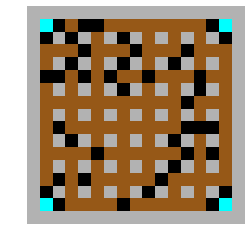

In [9]:
anim = animation(imgs[:40], interval=300)
HTML(anim.to_jshtml())

In [10]:
! rm anim/*
for i in range(len(imgs)):
    Image.fromarray(np.uint8(imgs[i]*255)).resize((17*10,17*10)).save('anim/{:0>3d}.png'.format(i))

In [16]:
! convert anim/*.png movie.gif

In [15]:
! apt-get install -y imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dbus fontconfig fontconfig-config fonts-dejavu-core fonts-droid-fallback
  fonts-noto-mono ghostscript gsfonts hicolor-icon-theme imagemagick-6-common
  imagemagick-6.q16 krb5-locales libapparmor1 libavahi-client3
  libavahi-common-data libavahi-common3 libbsd0 libcairo2 libcups2
  libcupsfilters1 libcupsimage2 libdatrie1 libdbus-1-3 libdjvulibre-text
  libdjvulibre21 libfftw3-double3 libfontconfig1 libfreetype6 libglib2.0-0
  libglib2.0-data libgraphite2-3 libgs9 libgs9-common libgssapi-krb5-2
  libharfbuzz0b libicu60 libidn11 libijs-0.35 libilmbase12 libjbig0
  libjbig2dec0 libjpeg-turbo8 libjpeg8 libk5crypto3 libkeyutils1 libkrb5-3
  libkrb5support0 liblcms2-2 liblqr-1-0 libltdl7 libmagickcore-6.q16-3
  libmagickcore-6.q16-3-extra libmagickwand-6.q16-3 libnetpbm10 libopenexr22
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 lib

Get:50 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcupsimage2 amd64 2.2.7-1ubuntu2.4 [18.6 kB]
Get:51 http://archive.ubuntu.com/ubuntu bionic/main amd64 libijs-0.35 amd64 0.35-13 [15.5 kB]
Get:52 http://archive.ubuntu.com/ubuntu bionic/main amd64 libjbig2dec0 amd64 0.13-6 [55.9 kB]
Get:53 http://archive.ubuntu.com/ubuntu bionic/main amd64 libpaper1 amd64 1.1.24+nmu5ubuntu1 [13.6 kB]
Get:54 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgs9-common all 9.26~dfsg+0-0ubuntu0.18.04.8 [5092 kB]
Get:55 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgs9 amd64 9.26~dfsg+0-0ubuntu0.18.04.8 [2262 kB]
Get:56 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 ghostscript amd64 9.26~dfsg+0-0ubuntu0.18.04.8 [51.2 kB]
Get:57 http://archive.ubuntu.com/ubuntu bionic/main amd64 gsfonts all 1:8.11+urwcyr1.0.7~pre44-4.4 [3120 kB]
Get:58 http://archive.ubuntu.com/ubuntu bionic/main amd64 hicolor-icon-theme all 0.17-2 [9976 B]
Get:59 http://archive.ubun

Selecting previously unselected package libicu60:amd64.
Preparing to unpack .../24-libicu60_60.2-3ubuntu3_amd64.deb ...
Unpacking libicu60:amd64 (60.2-3ubuntu3) ...
Selecting previously unselected package libxml2:amd64.
Preparing to unpack .../25-libxml2_2.9.4+dfsg1-6.1ubuntu1.2_amd64.deb ...
Unpacking libxml2:amd64 (2.9.4+dfsg1-6.1ubuntu1.2) ...
Selecting previously unselected package imagemagick-6-common.
Preparing to unpack .../26-imagemagick-6-common_8%3a6.9.7.4+dfsg-16ubuntu6.4_all.deb ...
Unpacking imagemagick-6-common (8:6.9.7.4+dfsg-16ubuntu6.4) ...
Selecting previously unselected package libmagickcore-6.q16-3:amd64.
Preparing to unpack .../27-libmagickcore-6.q16-3_8%3a6.9.7.4+dfsg-16ubuntu6.4_amd64.deb ...
Unpacking libmagickcore-6.q16-3:amd64 (8:6.9.7.4+dfsg-16ubuntu6.4) ...
Selecting previously unselected package libmagickwand-6.q16-3:amd64.
Preparing to unpack .../28-libmagickwand-6.q16-3_8%3a6.9.7.4+dfsg-16ubuntu6.4_amd64.deb ...
Unpacking libmagickwand-6.q16-3:amd64 (8:6.

Selecting previously unselected package libilmbase12:amd64.
Preparing to unpack .../70-libilmbase12_2.2.0-11ubuntu2_amd64.deb ...
Unpacking libilmbase12:amd64 (2.2.0-11ubuntu2) ...
Selecting previously unselected package libopenexr22:amd64.
Preparing to unpack .../71-libopenexr22_2.2.0-11.1ubuntu1_amd64.deb ...
Unpacking libopenexr22:amd64 (2.2.0-11.1ubuntu1) ...
Selecting previously unselected package libthai-data.
Preparing to unpack .../72-libthai-data_0.1.27-2_all.deb ...
Unpacking libthai-data (0.1.27-2) ...
Selecting previously unselected package libthai0:amd64.
Preparing to unpack .../73-libthai0_0.1.27-2_amd64.deb ...
Unpacking libthai0:amd64 (0.1.27-2) ...
Selecting previously unselected package libpango-1.0-0:amd64.
Preparing to unpack .../74-libpango-1.0-0_1.40.14-1ubuntu0.1_amd64.deb ...
Unpacking libpango-1.0-0:amd64 (1.40.14-1ubuntu0.1) ...
Selecting previously unselected package libpangoft2-1.0-0:amd64.
Preparing to unpack .../75-libpangoft2-1.0-0_1.40.14-1ubuntu0.1_amd6

update-alternatives: using /usr/bin/import-im6.q16 to provide /usr/bin/import (import) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/import.1.gz because associated file /usr/share/man/man1/import-im6.q16.1.gz (of link group import) doesn't exist
update-alternatives: using /usr/bin/import-im6.q16 to provide /usr/bin/import-im6 (import-im6) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/import-im6.1.gz because associated file /usr/share/man/man1/import-im6.q16.1.gz (of link group import-im6) doesn't exist
update-alternatives: using /usr/bin/identify-im6.q16 to provide /usr/bin/identify (identify) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/identify.1.gz because associated file /usr/share/man/man1/identify-im6.q16.1.gz (of link group identify) doesn't exist
update-alternatives: using /usr/bin/identify-im6.q16 to provide /usr/bin/identify-im6 (identify-im6) in auto mode
update-alternative